### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/ERA5_data/" + x

In [2]:
from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt
import gsw
import gc
from multiprocessing import Pool
import os 
import multiprocessing
from os.path import exists
sns.set_context("paper")
import dask_labextension

In [3]:
from pathlib import Path
from natsort import natsorted

In [4]:
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies
def remove_daily_climatology(ds):
    climatology = ds.groupby("time.dayofyear").mean("time")
    anomalies = ds.groupby("time.dayofyear") - climatology
    return anomalies

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='179GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=4)
from dask.distributed import Client
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=167G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/bin/python -m distributed.cli.dask_worker tcp://172.16.3.84:33726 --nthreads 36 --memory-limit 166.71GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.84:33726,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### We read in the Amaya Coastal Wave Index Amplitude $(\text{Index} =  \sqrt{\text{PC1}^2 + \text{PC2}^2)}$ and Phase $(\text{Phase} = atan( {\frac{\text{PC1}}{\text{PC2}}}))$ and recompute $\text{PC1}$ and $\text{PC2}$. We also remove the leap-year days from the GLORYS dataset.

In [15]:
#read in Amaya Coastal wave index 
ikw_Idx = xr.open_dataset(r"../GLORYS_processed/ikw.daily.glorys.1993-2018.nc").sel(time = slice("2000", None))
ikw_Idx["PC1"] = ikw_Idx.ikw_amp * np.cos(np.deg2rad(ikw_Idx.ikw_ph))
ikw_Idx["PC2"] = ikw_Idx.ikw_amp * np.sin(np.deg2rad(ikw_Idx.ikw_ph))

In [16]:
phases_dict = {}
phases_dict["1"] = np.argwhere((45 > ikw_Idx.ikw_ph.values) & (ikw_Idx.ikw_ph.values >=0) & (ikw_Idx.ikw_amp.values >1) )
phases_dict["2"] = np.argwhere((90 > ikw_Idx.ikw_ph.values) & (ikw_Idx.ikw_ph.values >=45) & (ikw_Idx.ikw_amp.values >1) )
phases_dict["3"] = np.argwhere((135 > ikw_Idx.ikw_ph.values) & (ikw_Idx.ikw_ph.values >=90) & (ikw_Idx.ikw_amp.values >1) )
phases_dict["4"] = np.argwhere((180 > ikw_Idx.ikw_ph.values) & (ikw_Idx.ikw_ph.values >=135) & (ikw_Idx.ikw_amp.values >1) )
phases_dict["5"] = np.argwhere((225 > ikw_Idx.ikw_ph.values) & (ikw_Idx.ikw_ph.values >=180) & (ikw_Idx.ikw_amp.values >1) )
phases_dict["6"] = np.argwhere((270 > ikw_Idx.ikw_ph.values) & (ikw_Idx.ikw_ph.values >=225) & (ikw_Idx.ikw_amp.values >1) )
phases_dict["7"] = np.argwhere((315 > ikw_Idx.ikw_ph.values) & (ikw_Idx.ikw_ph.values >=270) & (ikw_Idx.ikw_amp.values >1) )
phases_dict["8"] = np.argwhere((360 > ikw_Idx.ikw_ph.values) & (ikw_Idx.ikw_ph.values >=315) & (ikw_Idx.ikw_amp.values >1) )


In [17]:
def is_djf(month):
    return (month >= 1) & (month <= 2) | (month == 12)
def is_jfm(month):
    return (month >= 1) & (month <= 3) 

In [18]:
ikw_Idx_djf = ikw_Idx.isel(time = is_djf(ikw_Idx["time.month"]))

DJF_phases_dict = {}
DJF_phases_dict["1"] = np.argwhere((45 > ikw_Idx_djf.ikw_ph.values) & (ikw_Idx_djf.ikw_ph.values >=0) & (ikw_Idx_djf.ikw_amp.values >1) )
DJF_phases_dict["2"] = np.argwhere((90 > ikw_Idx_djf.ikw_ph.values) & (ikw_Idx_djf.ikw_ph.values >=45) & (ikw_Idx_djf.ikw_amp.values >1) )
DJF_phases_dict["3"] = np.argwhere((135 > ikw_Idx_djf.ikw_ph.values) & (ikw_Idx_djf.ikw_ph.values >=90) & (ikw_Idx_djf.ikw_amp.values >1) )
DJF_phases_dict["4"] = np.argwhere((180 > ikw_Idx_djf.ikw_ph.values) & (ikw_Idx_djf.ikw_ph.values >=135) & (ikw_Idx_djf.ikw_amp.values >1) )
DJF_phases_dict["5"] = np.argwhere((225 > ikw_Idx_djf.ikw_ph.values) & (ikw_Idx_djf.ikw_ph.values >=180) & (ikw_Idx_djf.ikw_amp.values >1) )
DJF_phases_dict["6"] = np.argwhere((270 > ikw_Idx_djf.ikw_ph.values) & (ikw_Idx_djf.ikw_ph.values >=225) & (ikw_Idx_djf.ikw_amp.values >1) )
DJF_phases_dict["7"] = np.argwhere((315 > ikw_Idx_djf.ikw_ph.values) & (ikw_Idx_djf.ikw_ph.values >=270) & (ikw_Idx_djf.ikw_amp.values >1) )
DJF_phases_dict["8"] = np.argwhere((360 > ikw_Idx_djf.ikw_ph.values) & (ikw_Idx_djf.ikw_ph.values >=315) & (ikw_Idx_djf.ikw_amp.values >1) )



### Reading in the GLORYS and ERA5 data files. Files have been preprocessed and combined in order to take advantage of the **dask** feature of xarray. We also remove their seasonal cliamtologies

In [19]:
%time
results = [str(result) for result in list(Path(GLORYS_dir()).rglob("*.[nN][cC]"))] #get all files
results = natsorted(results) #sort all files 
results = results[:-518] #only go to 2018

years = natsorted(list(set([result[41:45] for result in results])))
months = natsorted(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 10.5 µs


In [20]:
file_path = ERA5_data_dir()
ERA5_results = natsorted([str(result) for result in list(Path(file_path).rglob("*.[nN][cC]"))])[:-1]
results_ERA5 = natsorted([str(f) for f in ERA5_results if f[-7:-3] in years])

In [21]:
%%time 
def _preprocess(ds):
    return ds[["thetao", "zos"]].sel(latitude = slice(-2, 60), longitude = slice(-150, -75), time = slice("2000", "2018"))

ds = xr.open_mfdataset(
        GLORYS_data_dir("GLORYS_NE_PAC.nc"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        preprocess=_preprocess,
        parallel=True,
        chunks={"time":-1, "latitude":50, "longitude":50, "depth":2},
        engine="netcdf4")
ds_climatology = xr.open_dataset(GLORYS_data_dir("GLORYS_SFC_Climatology.nc"),
        chunks={"latitude":50, "longitude":50, "depth":2},
        engine="netcdf4")
glorys_anomalies = ds.groupby("time.dayofyear") - ds_climatology
glorys_anomalies["time"] = glorys_anomalies.indexes['time'].normalize()
glorys_anomalies = glorys_anomalies.sel(time = ikw_Idx.time.values)

CPU times: user 60.9 ms, sys: 2.88 ms, total: 63.8 ms
Wall time: 82.9 ms


In [22]:
def _preprocess_ERA5(ds):
    return ds.sel(latitude = slice(60, -2)).sel(longitude = slice(-150, -75)).sel(time = slice("2000", "2018"))

era5_ds = xr.open_mfdataset(GLORYS_data_dir("ERA5_NE_PAC_daily.nc"), 
        data_vars="minimal", coords="minimal",
        compat="override", preprocess=_preprocess_ERA5,
        parallel=True, chunks={"longitude": 119, "latitude":107, "time":-1}, engine="netcdf4")
era5_climatology = xr.open_dataset(ERA5_data_dir("ERA5_Daily_Climatology.nc"),
                    chunks={"longitude": 119, "latitude":107},
                    engine="netcdf4")
era5_anomalies = era5_ds.groupby("time.dayofyear") - era5_climatology
era5_anomalies["time"] = era5_anomalies.indexes['time'].normalize()
era5_anomalies = era5_anomalies.sel(time = ikw_Idx.time.values)

### iterate through the fields and take means for each phases with greater than 1 amplitude

In [26]:
SST_phase_dict = {}
precip_phase_dict = {}
tcwv_phase_dict = {}
z500_phase_dict = {}

In [32]:
phase = "5"
phase_indices = DJF_phases_dict["5"]

num_phases_days = len(phase_indices)
tp_anom_mean = era5_anomalies.tp.isel(time = phase_indices.flatten()).mean(dim = "time")
sst_anom_mean = glorys_anomalies.thetao.isel(depth = 0).isel(time = phase_indices.flatten()).mean(dim = "time")
tcwv_anom_mean = era5_anomalies.tcwv.isel(time = phase_indices.flatten()).mean(dim = "time")    
z500_anom_mean = era5_anomalies.z.isel(time = phase_indices.flatten()).mean(dim = "time")    

SST_phase_dict[phase] = sst_anom_mean
precip_phase_dict[phase] = tp_anom_mean
tcwv_phase_dict[phase] = tcwv_anom_mean
z500_phase_dict[phase] = z500_anom_mean / 1000 #scale from m -> km 
print(phase, len(phase_indices))

5 113


In [33]:
phase = "5"
phase_indices = DJF_phases_dict["5"]

SST_phase_dict[phase] = SST_phase_dict[phase].compute()
precip_phase_dict[phase] = precip_phase_dict[phase].compute()
tcwv_phase_dict[phase] = tcwv_phase_dict[phase].compute()
z500_phase_dict[phase] = z500_phase_dict[phase].compute() 

/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 0.8, 'Composites using Amaya Coastal Wave Index')

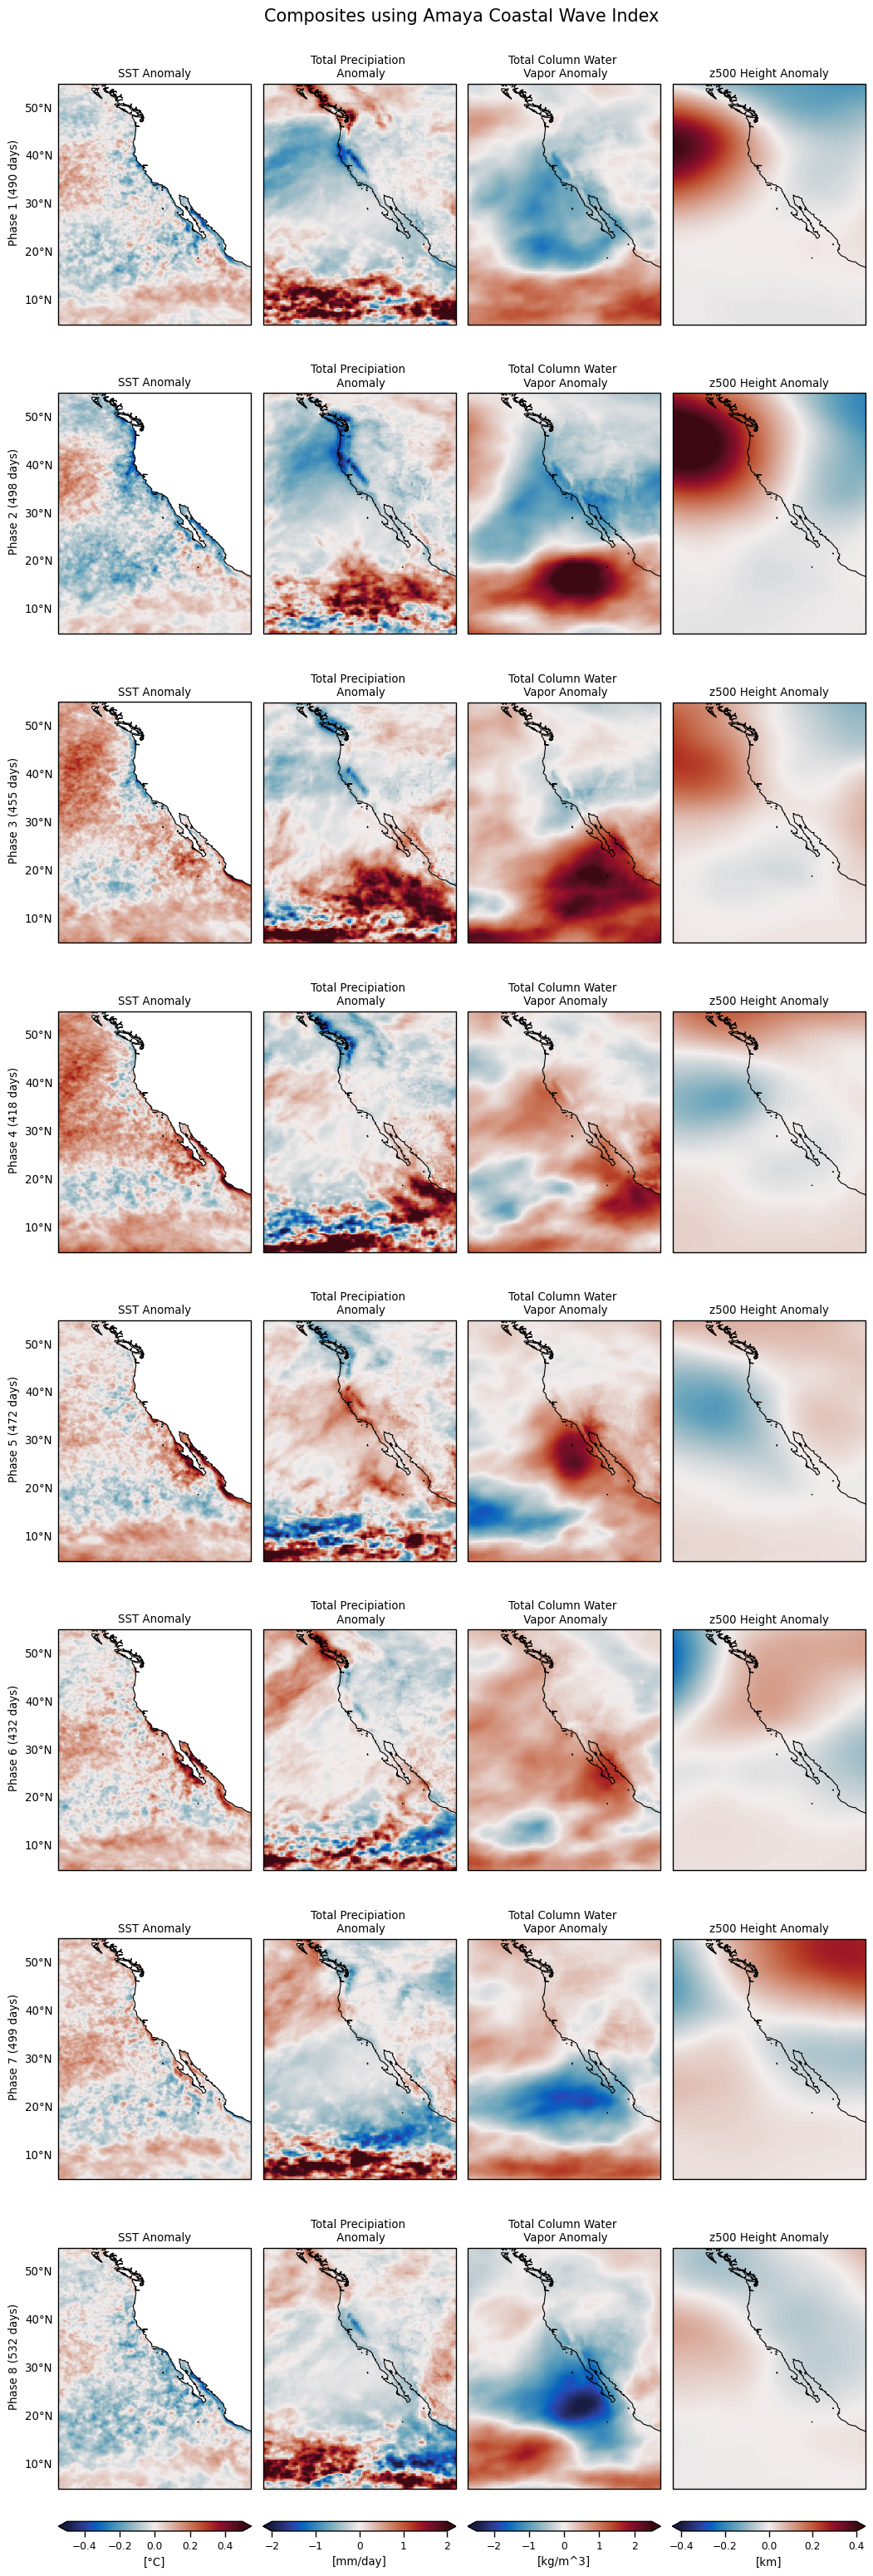

In [18]:
fig, axes = plt.subplots(ncols = 4, nrows = 8, figsize = (10, 40), subplot_kw={'projection': ccrs.PlateCarree()})
# fig.tight_layout()
for phase, phase_indices in phases_dict.items():
    phase_num = int(phase) - 1
    if phase != "8":
        SST_phase_dict[phase].sel(latitude = slice(5, 55), longitude = slice(-140, -100)).plot(ax = axes[phase_num, 0], cmap = cm.balance,
                                                                                              vmin = -0.5, vmax = 0.5, add_colorbar = False)
        precip_phase_dict[phase].sel(latitude = slice(55, 5)).sel(longitude = slice(-140, -100)).plot(ax = axes[phase_num, 1], cmap = cm.balance,
                                                                                              vmin = -2.0, vmax = 2.0, add_colorbar = False)
        tcwv_phase_dict[phase].sel(latitude = slice(55, 5)).sel(longitude = slice(-140, -100)).plot(ax = axes[phase_num, 2], cmap = cm.balance,
                                                                                              vmin = -2.5, vmax = 2.5, add_colorbar = False)
        z500_phase_dict[phase].sel(latitude = slice(55, 5)).sel(longitude = slice(-140, -100)).plot(ax = axes[phase_num, 3], cmap = cm.balance,
                                                                                              vmin = -0.4, vmax = 0.4, add_colorbar = False)
        fig.tight_layout()
    else:
        SST_phase_dict[phase].sel(latitude = slice(5, 55), longitude = slice(-140, -100)).plot(ax = axes[phase_num, 0], cmap = cm.balance,
                                                                                              vmin = -0.5, vmax = 0.5, add_colorbar = True,
                                                                                               cbar_kwargs = {"label":"[°C]", "extend": "both", 
                                                                                                              "orientation":"horizontal", "ax":axes[:, 0],
                                                                                                             "fraction":0.04, "pad":0.01})
        precip_phase_dict[phase].sel(latitude = slice(55, 5)).sel(longitude = slice(-140, -100)).plot(ax = axes[phase_num, 1], cmap = cm.balance,
                                                                                              vmin = -2.0, vmax = 2.0, add_colorbar = True,
                                                                                               cbar_kwargs = {"label":"[mm/day]", "extend": "both", 
                                                                                                              "orientation":"horizontal", "ax":axes[:, 1],
                                                                                                             "fraction":0.04, "pad":0.01})
        tcwv_phase_dict[phase].sel(latitude = slice(55, 5)).sel(longitude = slice(-140, -100)).plot(ax = axes[phase_num, 2], cmap = cm.balance,
                                                                                              vmin = -2.5, vmax = 2.5, add_colorbar = True,
                                                                                               cbar_kwargs = {"label":"[kg/m^3]", "extend": "both", 
                                                                                                              "orientation":"horizontal", "ax":axes[:, 2],
                                                                                                              "fraction":0.04, "pad":0.01})
        z500_phase_dict[phase].sel(latitude = slice(55, 5)).sel(longitude = slice(-140, -100)).plot(ax = axes[phase_num, 3], cmap = cm.balance,
                                                                                              vmin = -0.4, vmax = 0.4, add_colorbar = True,
                                                                                               cbar_kwargs = {"label":"[km]", "extend": "both", 
                                                                                                              "orientation":"horizontal", "ax":axes[:, 3],
                                                                                                              "fraction":0.04, "pad":0.01})                                                                                              

[ax.set_title("") for ax in axes.flatten()];
[ax.set_title("SST Anomaly") for ax in axes[:, 0].flatten()]
[ax.set_title("Total Precipiation \n Anomaly") for ax in axes[:, 1].flatten()]
[ax.set_title("Total Column Water \n Vapor Anomaly") for ax in axes[:, 2].flatten()]
[ax.set_title("z500 Height Anomaly") for ax in axes[:, 3].flatten()]


for (i, ax) in enumerate(axes[:, 0].flatten()):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.0, linestyle='--')
    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    
    ax.text(-0.2, 0.55, "Phase " + str(i+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
    
[ax.coastlines() for ax in axes.flatten()];
fig.suptitle("Composites using Amaya Coastal Wave Index", y= 0.7, fontsize = 20)
# [ax.set_ylabel(, transform=ax.transAxes) for (i, ax) in enumerate(axes[:, 0].flatten())];
fig.suptitle("Composites using Amaya Coastal Wave Index", y= 0.8, fontsize = 15)
# fig.savefig(plotsdir("AmayaVariableComposites.png"), bbox_inches = "tight")